Problem Set 3
=======


### Instructions / Notes:

**_Read these carefully_**

* **Please read all the points of the "Notes" sections- they're important for this PS!!!**
* **See the PS3 aggregator post on Piazza [here](https://piazza.com/class/ids5phnofkj2kr?cid=1028) for general info, post aggregatgions, and submission instructions!**
* _Have fun!_

Problem 1: Double Trouble
------------------------

**_[25 points total]_**

In this problem we'll explore an optimization often referred to as **_double buffering_**, which we'll use to speed up the **external merge sort algorithm** we saw in _Lecture 13_.

Although we haven't explicitly modeled it in many of our calculations so far, recall that _sequential IO_ (i.e. involving reading from / writing to consecutive pages on the physical disk) is generally much faster that _random access IO_ (any reading / writing that is not sequential).

In other words, for example, if we read 3 consecutive pages from file $A$, this should be much faster than reading 1 page from $A$, then 1 page from file $B$, then the next page from $A$ (assuming that the file layouts represent the actual physical layout on disk, as we will).  Conceptually, recall the image of the disk head having to move around the physical disk, versus just staying in place and reading sequentially as the disk spins.

**In this problem, we will begin to model this, by assuming that sequential _READS_ are "free", i.e. the cost of $N$ sequential reads is $1$ IO for any $N>0$**.

Note that we **do not** make this assumption for writes, i.e. writing $N$ pages sequentially still costs $N$ IO (this is to simplify our calculations below).

### Other important notes:
* **NO REPACKING:** Consider the external merge sort algorithm using the basic optimizations we present in section 1 of lecture 13, but do not use the repacking optimization (Lecture 13 : Slide 28 and on)
* **ONE BUFFER PAGE RESERVED FOR OUTPUT:** Assume we use one page for output in a merge, e.g. a $B$-way merge would require $B+1$ buffer pages
* **REMEMBER TO ROUND:** Take ceilings and/or floors (i.e. rounding up/down to the nearest integer) into account in this problem for full credit!  Note that we have sometimes omitted these (for simplicity) in lecture.
* **Consider worst case cost:** In other words, if 2 reads _could happen_ to be sequential, but in general might not be, consider these random IO
* **The pages of files and runs are arranged sequentially on the physical disk** i.e. you can assume that  sequential reads from a run / file _are_ always sequential!

### Part (a)

**_[5 points]_**

Consider a modification of the external merge sort algorithm where **during the merge phase, runs are ALWAYS read in 3-page chunks (i.e. 3 pages sequentially at a time).** The only time this may be violated is when you have reached the end of a run and there are < 3 pages left in that run.  Calculate the cost of performing this version of external merge sort for a setup having $B+1=10$ buffer pages and an unsorted input file with $90$ pages, showing the steps of your work.

Make sure to explain your reasoning in 2-3 sentences for full / partial credit.  Write your explanations as python comments, and save your final IO cost as `p1a_cost`:

In [31]:
p1a_cost = 345

_Explanation:_

1. First, we split the file into 9 sorted 10-page runs by loading 10 pages at a time into the buffer.  Reading each 10 page chunk in takes 1 IO, and writing it out takes 10 IO, so in total this step takes **9 * (1 + 10) = 99 IO**

2. Next, we do a first pass of the merge phase, doing **3-way merges** (the most we can fit in the buffer, since we are reading each run in 3-page chunks).  Each run of ten pages requires _4 3-page chunks_ i.e. 4 IO to read in, and 10 IO to read out.  Since we consider worst case cost, we consider this as the cost for all 9 runs, thus our cost is **9 * (4 + 10) = 126 IO**

3. Now we have three sorted runs of 30 pages each, and can do one final merge pass to produce the output file.  This time, each run requires _10 3-page chunks = 10 IO_ to read in, and 30 IO to write out, so our total cost for this step is **3 * (10 + 30) = 120 IO**

4. $\implies$ the total cost is **99 + 126 + 120 = 345 IO**

### Part (b)

**_[15 points]_**

Next, you'll generalize the reasoning above by writing a python function that computes the cost of performing this version of external merge sort for a setup having $B+1$ buffer pages, an unsorted input file with $N$ pages, and where **we always read in $P$-page chunks during the merge phase**.

We'll call this function `external_merge_sort_cost(B,N,P)`, and we'll compute it as the product of the cost of reading in and writing out all the data (which we do each pass), and the number of passes we'll have to do (plus the cost of initially sorting the runs).

**Importantly, to simplify your calculations: Your function will only be evaluated on cases where the following hold:**
* **(B + 1) % P == 0** (i.e. the buffer size is divisible by the chunk size)
* **N % (B + 1) == 0** (i.e. the file size is divisible by the buffer size)

#### Part (b.i)

*_[5 points]_*

First, write a python function that computes the total IO cost to create the initial runs:

In [32]:
def cost_initial_runs(B, N, P):
    
    # We make each run equal to the size of the buffer,
    # since this is the largest amount we can sort in memory
    
    # The IO cost to read in the run is 1,
    # and to write it out is B+1
    
    # There are N/(B+1) of these runs- no floor / ceiling is 
    # needed due to our assumption that N % (B + 1) == 0!
    return N + N/(B+1)

#### Part (b.ii)

*_[5 points]_*

Next, write a python function that computes the total IO cost to read in and then write out all the data during _one_ merge pass; note that, as in lecture, this should apply for any pass during our merge phase:

In [33]:
def cost_per_pass(B, N, P):
    
    # Note first of all that due to our simplifying assumption
    # that (B + 1) % P == 0, we will never run into the issue
    # seen in 1(a) where each merge pass may have a different cost
    
    # In more detail: our initial runs are of size B+1, and due
    # to this assumption, they are divisible by the chunk size P
    # thus there will never be partially-filled chunks being read in:
    # Thus on each merge pass, we read in exactly N / P chunks = N / P IO
    
    # And, if B+1 is divisible by P, then so are all multiples of it,
    # so this will hold for all passes of the merge phase, and 
    # the total read cost will always be the same (unlike in part a)!
    
    # And of course, total write IO per pass will just be N as before
    return N + N/P

#### Part (b.iii)
*_[5 points]_*



Next, write a python function that computes the total number of passes we'll need to do:

In [34]:
def num_passes(B, N, P):
    
    # We have N/(B+1) initial runs, and no floor/ceiling is needed
    # here due to our assumption (although no problem if there is)
    
    # We are doing floor(B/P)-way merges- note the floor is necessary here!
    
    # Finally, we can't do partial passes, so a ceiling is needed
    # Around the expression
    return math.ceil(math.log(N/(B+1), math.floor(B/float(P))))

Finally, our total cost function is:

In [35]:
def external_merge_sort_cost(B, N, P):
    return cost_initial_runs(B,N,P) + cost_per_pass(B,N,P)*num_passes(B,N,P)

### Part (c)

**_[5 points]_**

For $B=29$ and $N=900$, find the optimal $P$ according to your IO cost equation above.  Return both the optimal $P$ value (stored as `P_opt`) and the list of tuples **_for feasible values of $P$_** that would generate a plot, at resolution $=1$, stored as `points`, using the starter code below.

Additionally, plot your points _using some plotting software_* and describe what you see in one sentence (stored as a python comment).

*Below we provide starter code for using `matplotlib` in the notebook, if you were able to install this; however any other software that allows you to visualize the plot (Excel, Google spreadsheets, MATLAB, etc) is fine!

In [36]:
# Save the tuples to generate an IO cost plot vs. P here
B = 29
N = 900
feasible_p_range = range(1,15)
p1_points = [(p, external_merge_sort_cost(B, N, p)) for p in feasible_p_range]

# Save the optimal value here
P_opt = 4

# We see that as we initially increase P, we get gains due
# to the discounting of IO read cost; however after P=4,
# these are outweighed by the ability to merge fewer
# runs simultaneously!

Below, we provide _optional_ starter code for plotting with the `matplotlib` library:

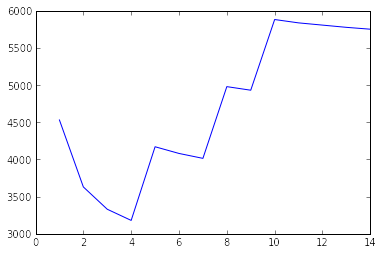

In [37]:
# Shell code for plotting in matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot: unpack the list of p,cost tuples and input as args to plot
plt.plot(*zip(*p1_points))
plt.show()

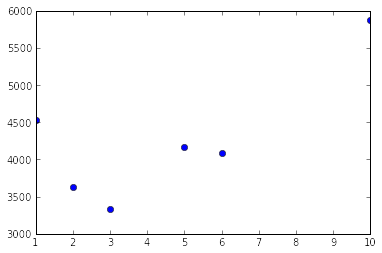

[(1, 4530.0), (2, 3630.0), (3, 3330.0), (5, 4170.0), (6, 4080.0), (10, 5880.0)]


In [38]:
# Plot the every-other-point chart
prange = [1, 2, 3, 5, 6, 10]
plt.plot(prange, [external_merge_sort_cost(B, N, p) for p in prange], 'o')
plt.show()
print [(p,external_merge_sort_cost(B, N, p)) for p in prange]

Additionally, below is a plot of **$P$ values that meet the divisibility assumptions** (i.e. ones that your function might be evaluated on) that you can check your answer against!

<img src="files/PS3-1-c.png">

And below, the actual points that make up the above plot for reference:

In [39]:
eval_points = [(1, 4530.0), (2, 3630.0), (3, 3330.0), (5, 4170.0), (6, 4080.0), (10, 5880.0)]

Problem 2: IO Cost Models
--------------------------------------

**_[15 points total]_**

In each part of this problem we consider two different join algorithms, joining relations $R(A,B)$ and $S(A,C)$, and you must provide an example scenario where one would be faster than the other.  Additionally, you will compute the total IO cost for each join algorithm in your example.

Specifically, for each part, you need to provide:

* `<PART>_P_R`: Number of pages of $R$
* `<PART>_P_S`: Number of pages of $S$
* `<PART>_B`: Number of pages in buffer
* `<PART>_IO_cost_1`: Total IO cost of first join algorithm
* `<PART>_IO_cost_2`: Total IO cost of second join algorithm

Also include a one sentence explanation for each part (as a python comment)

### Notes:
* **Use the "vanilla" versions of the algorithms as presented in lecture, _i.e. without any of the optimizations we mentioned_**
* **Again assume we use one page for output, as in lecture!**
* **_Do not include the IO cost of writing the final output ($OUT$ in lecture) in any of your calculations (since $OUT$ is the same, independent of which join algorithm we use!)_**

### Part (a)

*_[5 points]_*

Hash Join (HJ) is cheaper than Sort-Merge Join (SMJ) to join $R,S$

In [ ]:
A_P_R = 10
A_P_S = 100
A_B = 32

# HJ: We see that (B-1)^2 = 961 >> min{P(R), P(S)},
# so based on our calculations in lecture, we should
# be able to do the join in 3(P(R)+P(S)) = 330 IO

# In more detail, suppose we hash R and S into 31 buckets
# (first R, then S).  This will take 2(P(R)+P(S))
# At this point, assuming we don't have absurdly high skew,
# R and S should be partitioned into
# buckets of a few pages each, which is well below what
# we need to do BNLJ on the matching partitions in linear
# time i.e. P(R)+P(S)
A_IO_cost_1 = 330

# SMJ: R takes one pass to sort, S takes two
# = 2*P(R) + 4*P(S)
# After this, takes one more pass over each to join
# = 3*P(R) + 5*P(S) = 3*10 + 5*100
A_IO_cost_2 = 530

# Explanation: HJ will be cheaper when the smaller
# relation is very small, and the larger one very big,
# since it depends on the min while SMJ depends on the max

### Part (b)

**_[5 points]_**

HJ is cheaper than BNLJ to join $R,S$

In [ ]:
# Consider one of many possible solutions below:

B_P_R = 300
B_P_S = 300
B_B = 32

# HJ: We see that (B-1)^2 = 961 >> min{P(R), P(S)},
# so based on our calculations in lecture, we should
# be able to do the join in 3(P(R)+P(S)) = 1800 IO

# In more detail, suppose we hash R and S into 31 buckets
# (first R, then S).  This will take 2(P(R)+P(S))
# At this point, R and S should be partitioned into
# buckets of ~ 10 pages each, which is well below what
# we need to do BNLJ on the matching partitions in linear
# time i.e. P(R)+P(S)
B_IO_cost_1 = 1800

# BNLJ: From lecture, the cost is P(R) + (P(R)/(B-1))*P(S)
# = 300 + (300/30)*300 = 3300
B_IO_cost_2 = 3300

# Explanation: BNLJ is quadratic when neither relation
# fits in memory, while HJ is linear & only takes one pass
# if buckets fit in memory

### Part (c)

**_[5 points]_**

BNLJ is cheaper than SMJ to join $R,S$

In [ ]:
C_P_R = 10
C_P_S = 100
C_B = 12

# BNLJ: Same as in (b)... from lecture:
# = 10 + (10/10)*100 = 110
C_IO_cost_1 = 110

# SMJ: R takes one pass to sort, S takes two
# = 2*P(R) + 4*P(S)
# After this, takes one more pass over each to join
# = 3*P(R) + 5*P(S) = 3*10 + 5*100
C_IO_cost_2 = 530

# Explanation: BNLJ works great when one relation fits
# in memory!

Problem 3: Sequential Flooding
-----------------------------

**_[10 points total]_**

In the activity we went through in class for Lecture 15, we saw something called _sequential flooding_ that can occur when a default eviction policy (for example LRU) is used by the buffer manager.  We saw that we can achieve much lower IO cost by using a different eviction policy, MRU ("most recently used").

**Note that "Most recently used" means most recently accessed, either from buffer or disk, consistent with what we showed in Activity-15 in lecture.**

For this problem, specify the IO cost of reading in all the pages of an $N$-page file sequentially, $M$ times, using a buffer with $B+1$ pages, using an LRU and MRU eviction policy.  Assume that after reading the files, you don't need to write them out (you can just release them, so there is no write IO cost).

Write an explanation and also create two python functions, `lru_cost(N,M,B)` and `mru_cost(N,M,B)`. Finally, provide the tuples which generate the plot of **the absolute value of the difference between LRU and MRU in terms of IO cost** for $B=4$, $N=7$, and $M$ between 1 and 20 inclusive (saved as the variable `p3_points`)

In [2]:
def lru_cost(N, M, B):
    
    # For N <= B+1, you can read the data in once,
    # and then loop over it:
    if N <= B+1:
        return N
    
    # Otherwise, you end up needing to read in each
    # page each iteration!
    else:
        return N*M

In [3]:
# For the solutions, we'll break the answer cell into several parts...

# First, here is one way to calculate the MRU cost
# By essentially just re-implementing the core of the algorithm
# as presented in Activity-15 in lecture

# We include a pretty-printer option here, but also check out the fancy
# animation in Activity-15!

def mru_cost(N, M, B, verbose=False):
    """
    Calculate MRU cost by just re-implementing the algorithm's steps
    NOTE that this is distinct from how the actual algorithm is implemented!!
    (See Activity-15 source code for more here...)
    Verbose mode included, works for single-digit numbers at least
    """
    if verbose: print "**MRU will have a bar over it**\n"
    b = [None]*(B+1)
    mru = 0
    reads = 0
    prev_reads = 0
    for i in range(M):
        if verbose: print "Iteration %s:" % i
        for x in range(N):
            if x not in b:
                
                # If x is not in buffer already and there is an open
                # page in the buffer, load in here and mark as MRU
                if None in b:
                    j = b.index(None)
                    b[j] = x
                    mru = j
                
                # Else if x is not in buffer already, and buffer is full,
                # follow the eviction policy and replace the MRU page
                else:
                    b[mru] = x
                reads += 1
            
            # If x is already in buffer, just read from buffer and mark
            # This value as new MRU
            else:
                mru = b.index(x)
            if verbose:
                s = " ".join([" " if i != mru else "_" for i in range(B+1)]) + "\n" + " ".join(map(str,b))
                s += "  [R]" if (reads - prev_reads) > 0 else ""
                prev_reads = reads
                print s
    return reads

In [4]:
B = 4
N = 7
M = 20
p3_points = [(m, abs(lru_cost(N, m, B) - mru_cost(N, m, B))) for m in range(1, M+1)]

Again, you can optionally plot your answer to check that it seems reasonable- starter code for doing this in the notebook below:

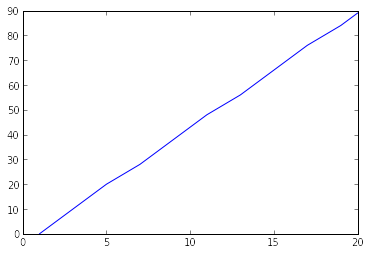

In [5]:
# Shell code for plotting in matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
plt.plot(*zip(*p3_points))
plt.show()

Problem 4: Don't Drink and Hash Collide
-------------------------------------

**_[10 points total]_**

**_Imagine the following scenario:_**  You are the chief culinary training officer of a high-end nation-wide restaurant chain, and you are overwhelmed because today is the end of your latest training program, and you have to assign $10,000$ newly-minted chefs each to one of your chain's $100$ restaurants.

You decide that to do this both fairly and uniformly, you'll create a hash function, which takes in a chef's ID and _uniformly_ outputs a number between 0 and 99.  The chef ids are each the letter "C" followed by four digits, zero-padded, so that ids look like:

> C0000

> C0001

> C0002

> ...

> C9998

> C9999

Each chef has a unique ID.  You decide to try the hash function:

In [6]:
def h(x, n):
    return sum(map(ord, x)) % n

If this hash function works properly, each bucket / restaurant should have $\approx100$ new chefs assigned to it.

Furthermore, as often does in fact happen in practice (with actual algorithms... roughly), the speed of your restaurant chain is proportional to the _sum of the squared number of chefs in each restaurant (i.e. the "bucket sizes")_.  In other words, if in restaurants `1, 2, 3, ...` there are `100, 150, 92, ...` chefs respectively, then your restaurant chain's overall speed will be $\propto 100^2 + 150^2 + 92^2 + ...$.

Intuitively, at a rough level, this is saying that too many chefs in one kitchen slows things down greatly...

You expect your hash function to distribute the chefs uniformly though, so you don't expect this to be an issue.  However, your restaurant chain ends up running much more slowly than expected!!  You decide to try to figure out why...

### Part (a)

**_[9 points]_**

#### Part (a.i)

*_[3 points]_*

Make a histogram of the bucket sizes (using the above hash function h) to help figure out what is going wrong.  You can plot your histogram with `matplotlib` if you have it installed, but all that we require is the list of tuples that would make the histogram (the bucket / restaurant ID, number of chefs assigned pairs), saved as `points`.

In [7]:
# C- total number of chefs (10000 in our example)
# R- number of restaurants (100 in our example)
# return value - list of tuples representing (restaurant ID, number of chefs assigned to that restaurant) points

from collections import Counter

def histogramPoints(C,R):
    return list(Counter([h('C%04d' % cid, R) for cid in range(C)]).iteritems())

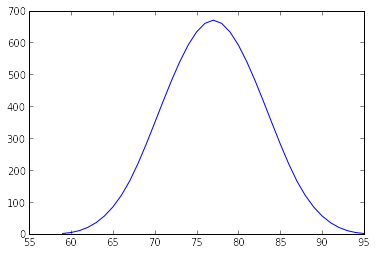

In [8]:
# Shell code for plotting in matplotlib (don't need to complete or turn in)
%matplotlib inline
import matplotlib.pyplot as plt
chefPoints = histogramPoints(10000, 100)

ids = [point[0] for point in chefPoints]
chefCounts = [point[1] for point in chefPoints]

# Plot
plt.plot(ids, chefCounts)
plt.show()

#### Part (a.ii)
*_[3 points]_*


Now find the skew associated with the above histogram. Skew is defined as the standard deviation of the number of entries in the buckets. A uniform hash function produces buckets of equal size, leading to 0 skew, but our candidate hash function h is imperfect so you should observe a positive skew.


In [9]:
# C- total number of chefs (10000 in our example)
# R- number of chefs per restaurant (100 in our example)
# return value - a float representing the skew of hash function (i.e. stdev of chefs assigned to each restaurant)

import numpy as np

def calculateSkew(C,R):
    return np.std([p[1] for p in chefPoints])

skew = calculateSkew(10000,100)
print skew

238.991535375


#### Part (a.iii)
*_[3 points]_*


Suppose that your application is quadratic in the number of items in a bucket, i.e. if your buckets have sizes $112, 150, 80, ...$ your runtime will be $112^2 + 150^2 + 80^2, ...$.  Compute how much larger your running time is than what you'd expect if the buckets were in fact uniform.

_Note: you may approximate by assuming that $C \% R == 0$ here, if this is helpful_

In [11]:
# C- total number of chefs (10000 in our example)
# R- number of chefs per restaurant (100 in our example)
# return value - difference between real runtime (with some skew) and ideal (no skew)
def runtimeDiff(C,R):
    
    # Assuming C % R == 0
    return sum([float(p[1])**2 for p in chefPoints]) - R*(C/R)**2

print runtimeDiff(10000,100)

3816030.0


### Part (b)

**_[1 point]_**

Use python's hash function to see if you can produce a better (aka smaller) runtime. As in part (a), make a histogram of the bucket sizes (this time using the new hash function). You can plot your histogram with `matplotlib` if you have it installed, but all that we require is the list of tuples that would make the histogram (the bucket / restaurant ID, number of chefs assigned pairs), saved as `points`. Hint: This solution should look *very* similar to (a.i)

In [12]:
# C- total number of chefs (10000 in our example)
# R- number of chefs per restaurant (100 in our example)
# return value - list of tuples representing (restaurant ID, number of chefs assigned to that restaurant) points
def betterHistogramPoints(C,R):
    return list(Counter([hash('C%04d' % cid) % R for cid in range(C)]).iteritems())

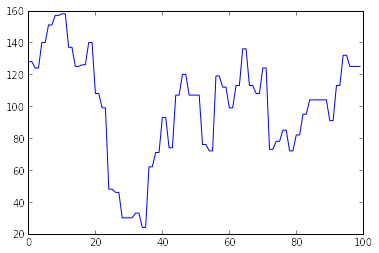

In [13]:
# Shell code for plotting in matplotlib (don't need to complete or turn in)
%matplotlib inline
import matplotlib.pyplot as plt
betterChefPoints = betterHistogramPoints(10000, 100)

betterIds = [point[0] for point in betterChefPoints]
betterChefCounts = [point[1] for point in betterChefPoints]

# Plot
plt.plot(betterIds, betterChefCounts)
plt.show()

Bonus Problem: Hash Away
-------------------------------------

**_[5 points total]_**

Design a better hash function that partitions the chefs more uniformly.  Return the tuples of the new histogram (again, plot if you want to), and the new runtime difference as in the previous part.  Note that there is no _best_ solution here- feel free to be creative, just make sure you see an improvement of some sort!

**Hint: Feel free to check out other hash functions out on the internet- e.g. Java's, python's- for inspiration**

_Many possible solutions- as long as answer is (a) not hard-coded for the input dataset (i.e. would only work for the set of chef-IDs in this problem) and (b) has better skew & runtime performance than the default hash function in 4(b), solution will be counted as correct!_